# Problem 1

### Getting familiar with loading, visualizing and operating on multivariate data

A Hess diagram is a 2D plot coded by a third quantity.

Here's an example from the [astroML documentation](https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html) showing the temperature and surface gravity (how strongly the star would pull on you if you could stand on it's surface, including the effect of rotation), color coded on the left by density, and on the right by metallicity (measured here as the ratio of iron to hydrogen) with density contours.


<img src="https://www.astroml.org/_images/plot_SDSS_SSPP_1.png">

From http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/, download one of the HLC\*fits.gz files (and use `astropy.io.fits` to load one of them)

The HLC files are each different bands on the sky.

You should separate stars and galaxies by using the `MEAN_OBJECT_TYPE` column and making a cut with value > 5 to find stars (and similarly <=5 to find galaxies).

For this problem, we want to make stars and galaxies make a 3-panel plot.

In the left plot show `r` vs `g-i` color coded by density (I would suggest numpy.histogram2d and matplotlib.pyplot.pcolormesh, but you can use whatever). Plot the contours on top.

In the middle and right panel, again plot `r` vs `g-i`, but now color-coded by proper motion in RA, and Dec.

Comment on the diffeence in structure in stars vs galaxies.

In [3]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm
%matplotlib inline

### Reading the file

In [4]:
path = "HLC.RA_20_to_21.fits"
hlc = fits.open(path)
hlc[1].data.columns

ColDefs(
    name = 'LC_NAME'; format = '46A'
    name = 'IAU_NAME'; format = '24A'
    name = 'N_GOOD_EPOCHS'; format = '5I'
    name = 'MEAN_PSFMAG'; format = '5E'
    name = 'MEAN_PSFMAG_ERR'; format = '5E'
    name = 'MEAN_EXPMAG'; format = '5E'
    name = 'MEAN_EXPMAG_ERR'; format = '5E'
    name = 'RMS_PSFMAG'; format = '5E'
    name = 'RMS_EXPMAG'; format = '5E'
    name = 'CHISQ_PSFMAG'; format = '5E'
    name = 'CHISQ_EXPMAG'; format = '5E'
    name = 'N_GOOD_EPOCHS_PSF_CLIP'; format = '5I'
    name = 'N_GOOD_EPOCHS_EXP_CLIP'; format = '5I'
    name = 'MEAN_PSFMAG_CLIP'; format = '5E'
    name = 'MEAN_PSFMAG_ERR_CLIP'; format = '5E'
    name = 'MEAN_EXPMAG_CLIP'; format = '5E'
    name = 'MEAN_EXPMAG_ERR_CLIP'; format = '5E'
    name = 'RMS_PSFMAG_CLIP'; format = '5E'
    name = 'RMS_EXPMAG_CLIP'; format = '5E'
    name = 'CHISQ_PSFMAG_CLIP'; format = '5E'
    name = 'CHISQ_EXPMAG_CLIP'; format = '5E'
    name = 'MEAN_PSFMAG_ITER'; format = '5E'
    name = 'MEAN_PSFMAG_ERR_ITE

### Extracting the columns I need

In [8]:
obj = hlc[1].data['MEAN_OBJECT_TYPE']
psfmag = hlc[1].data['MEAN_PSFMAG']
ra = hlc[1].data['RA_PM']
dec = hlc[1].data['DEC_PM']

In [9]:
psfmag

array([[ 0.      , 20.5409  , 19.1235  ,  0.      , 17.2445  ],
       [21.99887 , 20.877666, 20.40503 , 20.200876, 20.114264],
       [ 0.      , 23.2873  , 22.499111, 21.154667, 20.228382],
       ...,
       [ 0.      ,  0.      , 22.305151, 21.007761, 20.182236],
       [20.998291, 18.404652, 16.98328 , 16.270557, 15.851689],
       [21.3048  , 20.6689  , 20.3322  , 20.1384  , 20.0779  ]],
      dtype=float32)

In [6]:
print(ra.shape)
print(dec.shape)
print(psfmag.shape)
print(obj.shape)

(390491,)
(390491,)
(390491, 5)
(390491,)


### Making my dataframe to work with the data easier

In [10]:
df = pd.DataFrame(psfmag.byteswap().newbyteorder()) # this is to avoid an error I was getting regarding fits file
#df=pd.DataFrame(np.array(d).byteswap().newbyteorder())
df.columns=['u', 'g', 'r', 'i', 'z']
df

,u,g,r,i,z
0,0.000000,20.540899,19.123501,0.000000,17.244499
1,21.998871,20.877666,20.405029,20.200876,20.114264
2,0.000000,23.287300,22.499111,21.154667,20.228382
3,0.000000,22.290159,20.914368,19.934971,19.400484
4,0.000000,22.197002,20.890553,20.076084,19.630083
...,...,...,...,...,...
390486,19.252880,17.762104,17.209421,17.016161,16.927181
390487,0.000000,0.000000,0.000000,21.355412,20.420748
390488,0.000000,0.000000,22.305151,21.007761,20.182236
390489,20.998291,18.404652,16.983280,16.270557,15.851689


In [11]:
df['ra'] = ra
df['dec'] = dec
df.head()

,u,g,r,i,z,ra,dec
0,0.000000,20.540899,19.123501,0.000000,17.244499,0.000000,0.000000
1,21.998871,20.877666,20.405029,20.200876,20.114264,0.004302,-0.004444
2,0.000000,23.287300,22.499111,21.154667,20.228382,0.002591,-0.015842
3,0.000000,22.290159,20.914368,19.934971,19.400484,0.004236,-0.011124
4,0.000000,22.197002,20.890553,20.076084,19.630083,0.005476,-0.006286


### Using MEAN_OBJECT_TYPE column, if data>5, it's star and I save it as 1 in star column
### if data<=5 then it is a galaxy and I save it as one in galaxy column

In [12]:
# stars >5 , galaxies <= 5
stars = np.where(obj>5, 1, 0)
galaxies = np.where(obj<=5, 1, 0)
df['star'] = stars
df['galaxy'] = galaxies
df.head()

,u,g,r,i,z,ra,dec,star,galaxy
0,0.000000,20.540899,19.123501,0.000000,17.244499,0.000000,0.000000,1,0
1,21.998871,20.877666,20.405029,20.200876,20.114264,0.004302,-0.004444,1,0
2,0.000000,23.287300,22.499111,21.154667,20.228382,0.002591,-0.015842,1,0
3,0.000000,22.290159,20.914368,19.934971,19.400484,0.004236,-0.011124,1,0
4,0.000000,22.197002,20.890553,20.076084,19.630083,0.005476,-0.006286,0,1


### Keeping positive magnitudes only

In [13]:
df = df[(df['r']>0) & (df['g']>0) & (df['i']>0)]

In [14]:
df['g-i'] = df['g'] - df['i']
df.head()

<ipython-input-14-98a81206a117>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['g-i'] = df['g'] - df['i']


,u,g,r,i,z,ra,dec,star,galaxy,g-i
1,21.998871,20.877666,20.405029,20.200876,20.114264,0.004302,-0.004444,1,0,0.676790
2,0.000000,23.287300,22.499111,21.154667,20.228382,0.002591,-0.015842,1,0,2.132633
3,0.000000,22.290159,20.914368,19.934971,19.400484,0.004236,-0.011124,1,0,2.355188
4,0.000000,22.197002,20.890553,20.076084,19.630083,0.005476,-0.006286,0,1,2.120918
5,0.000000,23.202999,21.794518,20.595776,19.886591,-0.012271,-0.003149,1,0,2.607224


### Making 2 different dataframes for stars and galaxies

In [15]:
# make 2 different dataframes, 1 for stars and 1 for galaxies
df_stars = df[df['star']==1]
df_gal = df[df['galaxy']==1]

In [16]:
print(df_stars.size)
df_stars.head()

2621770


,u,g,r,i,z,ra,dec,star,galaxy,g-i
1,21.998871,20.877666,20.405029,20.200876,20.114264,0.004302,-0.004444,1,0,0.676790
2,0.000000,23.287300,22.499111,21.154667,20.228382,0.002591,-0.015842,1,0,2.132633
3,0.000000,22.290159,20.914368,19.934971,19.400484,0.004236,-0.011124,1,0,2.355188
5,0.000000,23.202999,21.794518,20.595776,19.886591,-0.012271,-0.003149,1,0,2.607224
6,0.000000,23.084919,21.800549,20.080723,19.249033,-0.011608,0.002658,1,0,3.004196


In [17]:
df_stars = df_stars[df_stars['g-i']>0] # double check everything is positive
print(df_stars.size)
df_stars.head()

2616440


,u,g,r,i,z,ra,dec,star,galaxy,g-i
1,21.998871,20.877666,20.405029,20.200876,20.114264,0.004302,-0.004444,1,0,0.676790
2,0.000000,23.287300,22.499111,21.154667,20.228382,0.002591,-0.015842,1,0,2.132633
3,0.000000,22.290159,20.914368,19.934971,19.400484,0.004236,-0.011124,1,0,2.355188
5,0.000000,23.202999,21.794518,20.595776,19.886591,-0.012271,-0.003149,1,0,2.607224
6,0.000000,23.084919,21.800549,20.080723,19.249033,-0.011608,0.002658,1,0,3.004196


In [18]:
df_gal = df_gal[df_gal['g-i']>0]
print(df_gal.size)
df_gal.head()

619250


,u,g,r,i,z,ra,dec,star,galaxy,g-i
4,0.0000,22.197002,20.890553,20.076084,19.630083,0.005476,-0.006286,0,1,2.120918
7,0.0000,22.859997,21.906811,21.277205,19.965500,-0.024490,-0.028792,0,1,1.582792
9,0.0000,22.382515,21.610054,21.243469,20.716581,0.011049,-0.022536,0,1,1.139046
13,22.1681,21.611311,21.083387,20.791447,20.398836,-0.012206,-0.001982,0,1,0.819864
20,0.0000,21.577419,20.606194,20.644751,19.886652,-0.007411,0.008852,0,1,0.932669


### 3-panel plot r vs g-i . Left plot color coded by density, middle and right plots color coded by RA_PM & DEC_PM columns

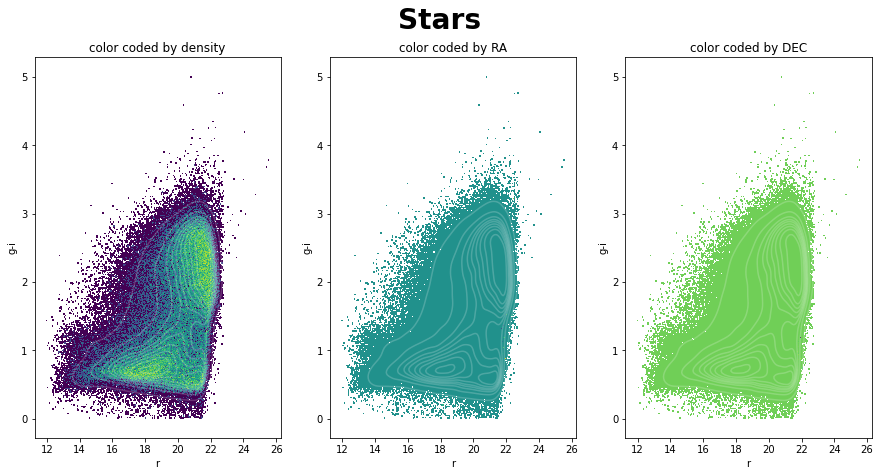

In [20]:
# 3-panel plot for stars using df_stars
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Stars',size=28,fontweight="bold")


# left image "r vs g-i color coded by density"

# bi-dimensional histogram of two data samples
H, xedges, yedges = np.histogram2d(x=df_stars['r'], y=df_stars['g-i'], bins=500)
#print(H)
# I had to convert 0 in H to np.nan otherwise I had a black background!! OLD APPROACH
#H_new = np.where(H==0, np.nan, H)
#print(H_new)
ax1.set_title('color coded by density')
ax1.pcolormesh(xedges, yedges, H.T, alpha=1, norm=LogNorm())
sns.kdeplot(data=df_stars, x=df_stars['r'], y=df_stars['g-i'], 
                ax=ax1, color='white', alpha=0.2)


# In the middle and right panel, again plot r vs g-i, but now color-coded by proper motion in RA, and Dec

# binned_statistic_2d return xedges,yedges & statistics. statistics is the first element [0]
H_ra = binned_statistic_2d(x=df_stars['r'], y=df_stars['g-i'], values=df_stars['ra'],bins=500)
#print(H_ra)
ax2.set_title('color coded by RA')
ax2.pcolormesh(xedges, yedges, H_ra[0].T, alpha=1)
sns.kdeplot(data=df_stars, x=df_stars['r'], y=df_stars['g-i'], 
                ax=ax2, color='white', alpha=0.2)
#print(H_ra[0])

H_dec = binned_statistic_2d(x=df_stars['r'], y=df_stars['g-i'], values=df_stars['dec'],bins=500)
ax3.set_title('color coded by DEC')
ax3.pcolormesh(xedges, yedges, H_dec[0].T, alpha=1)
sns.kdeplot(data=df_stars, x=df_stars['r'], y=df_stars['g-i'], 
                ax=ax3, color='white', alpha=0.2)


plt.show(fig)

#### ** OLD APPROACH **
I printed H form histogram2d and realized that a lot of the elements are nan!
But when I printed the statistics form binned_statistic_2d, they were 0 and since the next two right plots have the correct white background, then I changed nan in H to 0
It might be wrong but before that my background was purple instead!

#### ** NEW APPROACH **
someone in Slack suggested to use LogNorm!

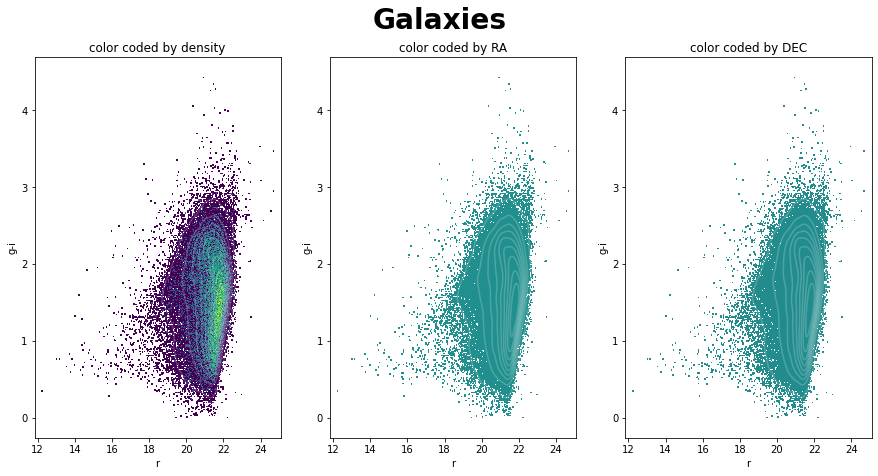

In [24]:
# 3-panel plot for stars using df_stars
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
fig.suptitle('Galaxies',size=28,fontweight="bold")


# left image "r vs g-i color coded by density"

# bi-dimensional histogram of two data samples
H, xedges, yedges = np.histogram2d(x=df_gal['r'], y=df_gal['g-i'], bins=500)
ax1.set_title('color coded by density')
ax1.pcolormesh(xedges, yedges, H.T, alpha=1, norm=LogNorm())
sns.kdeplot(data=df_gal, x=df_gal['r'], y=df_gal['g-i'], 
                ax=ax1, color='white', alpha=0.2)


# In the middle and right panel, again plot r vs g-i, but now color-coded by proper motion in RA, and Dec

# binned_statistic_2d return xedges,yedges & statistics. statistics is the first element [0]

H_ra = binned_statistic_2d(x=df_gal['r'], y=df_gal['g-i'], values=df_gal['ra'],bins=500)[0]
ax2.set_title('color coded by RA')
ax2.pcolormesh(xedges, yedges, H_ra.T, alpha=1)
sns.kdeplot(data=df_gal, x=df_gal['r'], y=df_gal['g-i'], 
                ax=ax2, color='white', alpha=0.2)

H_dec = binned_statistic_2d(x=df_gal['r'], y=df_gal['g-i'], values=df_gal['dec'],bins=500)[0]
ax3.set_title('color coded by DEC')
ax3.pcolormesh(xedges, yedges, H_dec.T, alpha=1)
sns.kdeplot(data=df_gal, x=df_gal['r'], y=df_gal['g-i'], 
                ax=ax3, color='white', alpha=0.2)

plt.show(fig)

### Structural differences between stars and galaxies:

#### I don't have any background in astrophysics but by looking at the contours I can say that stars are more spread out than galaxies. The contour lines in galaxies are closer which means steeper slope in the magnitude whereas in stars not only I can see 3 different contours but also gentler slope in the magnitude. 


# Problem 2

### Comparing distributions to a standard normal distribution

Load the `IntroStat_demo.csv` file in the data directory (use `pandas` or `astropy` or whatever you like).

Estimate the sample mean and variance of the suspiciously named `mag.outlier` column.

Make a Q-Q plot (I suggest statsmodels.graphics.gofplots.qqplot) of the `mag.outlier` column and over plot a line with `Y = Mean + Sigma*X` on it. 

Calculate the values of the first and third quartiles, and use some linear algebra to figure out the equation of a line passing through them (google line 2 point form if you need a refresher on the linear algebra)

Overplot that line passing through the data.

Now try the same thing with `mag.het`. Describe what you found?

What happens if you rescale the data? Subtract of the sample mean of `mag.het` and divide by `mag.het.error`. Now repeat the Q-Q plot with this quantity. 

Describe what's going on.

In [34]:
import pandas as pd
import numpy as np
from statsmodels.graphics import gofplots
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.visualization import hist as ahist
%matplotlib inline

### Reading the file

In [35]:
path = "data/IntroStat_demo.csv"
df = pd.read_csv(path)
df.head()

,time,mag.hom,mag.outlier,mag.t,mag.het,mag.het.error,mag5,mag5.error
0,0.000000,18.558944,18.530677,18.560527,18.567447,0.067345,18.546056,0.009766
1,0.176158,18.531178,18.551560,18.549906,18.547315,0.017149,18.542605,0.007709
2,0.250165,18.553669,18.468095,18.544618,18.564191,0.020600,18.536269,0.009777
3,1.426983,18.539475,18.537368,18.560818,18.554162,0.074339,18.545782,0.008705
4,1.677148,18.575442,18.790521,18.556126,18.514765,0.027469,18.553644,0.010084


In [36]:
df.describe()

,time,mag.hom,mag.outlier,mag.t,mag.het,mag.het.error,mag5,mag5.error
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,6.136984,18.549847,18.561082,18.548757,18.548341,0.051951,18.558038,0.007977
std,3.047411,0.011652,0.071768,0.018684,0.045606,0.027883,0.011059,0.002905
min,0.000000,18.525782,18.468095,18.465040,18.416340,0.001280,18.536269,0.003256
25%,3.796514,18.541414,18.537395,18.540136,18.529209,0.028581,18.548388,0.005869
50%,6.129040,18.549526,18.553712,18.548791,18.553247,0.052331,18.558493,0.007636
75%,8.487105,18.556137,18.562982,18.557355,18.570570,0.076174,18.564478,0.009766
max,11.757748,18.580776,19.050590,18.603316,18.686296,0.098529,18.588580,0.019177


In [37]:
df['mag.outlier'].size

74

### Estimating mean, variance and standard variation

In [38]:
mean = df['mag.outlier'].mean()
var = df['mag.outlier'].var()
std = df['mag.outlier'].std()
mean, var, std

(18.561082466856572, 0.005150698425781927, 0.07176836647006762)

### Line to plot based on data from mag.outlier over Q-Q plot

In [39]:
#Y = Mean + Sigma*X  , X is mag.outlier
Y = mean + std * df['mag.outlier']
print(Y.shape)

(74,)


### Making a Q-Q plot of the mag.outlier with Y line over it

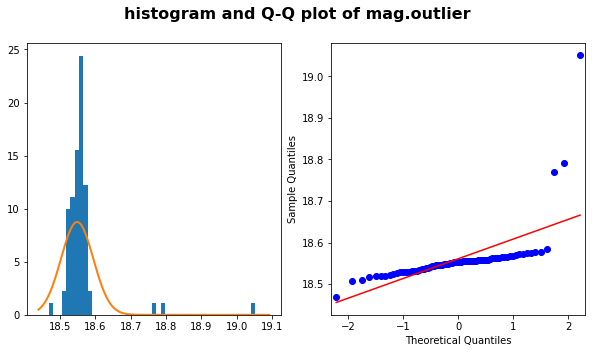

In [52]:
# method is from methods of moment in lecture example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('histogram and Q-Q plot of mag.outlier', size=16,fontweight="bold")
# let's histogram the sample we have 
ahist(df['mag.outlier'], bins='freedman', density=True, ax=ax1)
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# and overplot the PDF we estimate using the method of moments
estpdf  = st.norm.pdf(xval, loc=mean, scale=std)
ax1.plot(xval, estpdf, color='C1', lw=2)

gofplots.qqplot(df['mag.outlier'], line='r', ax=ax2)
plt.show()

### Calculating first and third quartiles.
There are different ways to calculate quartiles, np.percentile, df.describe & scipy.stats

In [42]:
df['mag.outlier'].describe()

count    74.000000
mean     18.561082
std       0.071768
min      18.468095
25%      18.537395
50%      18.553712
75%      18.562982
max      19.050590
Name: mag.outlier, dtype: float64

In [43]:
quartiles = st.scoreatpercentile(df['mag.outlier'], [25,75])
quartiles

array([18.53739527, 18.56298226])

### Calculating line passing through quartiles
I have first and third quartiles from statistics, now I need points at those percentages
https://towardsdatascience.com/exploring-normal-distribution-with-jupyter-notebook-3645ec2d83f8
very nice explanation!

In [44]:
# percent point function
p1=st.norm.ppf(q=0.25)
p2=st.norm.ppf(q=0.75)
p1, p2

(-0.6744897501960817, 0.6744897501960817)

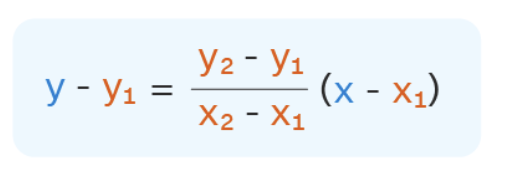

In [45]:
X = np.arange(-2, 2, 0.001) # range is based on the qq plot
y1, y2 = quartiles[0], quartiles[1]
x1, x2 = p1, p2

In [46]:
slope = (y2 - y1)/(x2 - x1)
L = (slope * (X - x1)) + y1
L

array([18.51225344, 18.51227241, 18.51229138, ..., 18.58806718,
       18.58808615, 18.58810512])

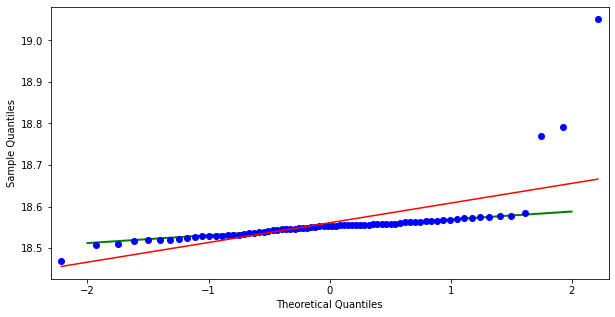

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(X, L, color='green', lw=2)

gofplots.qqplot(df['mag.outlier'], line='r', ax=ax)
plt.show()

### Trying the same thing with mag.het

In [50]:
mean, var, std = df['mag.het'].mean(), df['mag.het'].var(), df['mag.het'].std()
Y = mean + std * df['mag.het']
quartiles = st.scoreatpercentile(df['mag.het'], [25,75])
y1, y2 = quartiles[0], quartiles[1]
X = np.arange(-2, 2, 0.001)
slope = (y2 - y1)/(x2 - x1)
L = (slope * (X - x1)) + y1

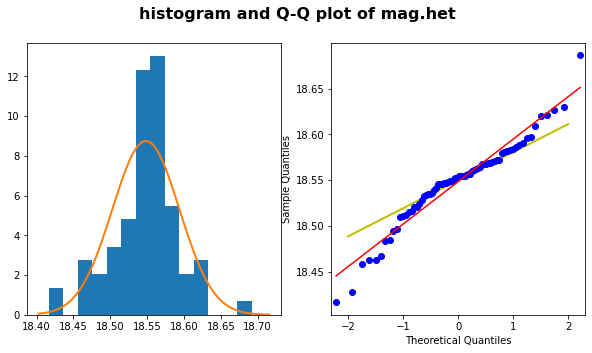

In [53]:
# method is from methods of moment in lecture example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('histogram and Q-Q plot of mag.het', size=16,fontweight="bold")
# let's histogram the sample we have 
ahist(df['mag.het'], bins='freedman', density=True, ax=ax1)
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# and overplot the PDF we estimate using the method of moments
estpdf  = st.norm.pdf(xval, loc=mean, scale=std)
ax1.plot(xval, estpdf, color='C1', lw=2)

ax2.plot(X, L, color='y', lw=2)

gofplots.qqplot(df['mag.het'], line='r', ax=ax2)
plt.show()

### Repeating Q-Q plot with subtraction of the sample mean of mag.het and divide by mag.het.error

In [54]:
mean_het = df['mag.het'].mean()
df['new.mag.het'] = (df['mag.het'] - mean_het)/df['mag.het.error']
df.head()

,time,mag.hom,mag.outlier,mag.t,mag.het,mag.het.error,mag5,mag5.error,new.mag.het
0,0.000000,18.558944,18.530677,18.560527,18.567447,0.067345,18.546056,0.009766,0.283706
1,0.176158,18.531178,18.551560,18.549906,18.547315,0.017149,18.542605,0.007709,-0.059827
2,0.250165,18.553669,18.468095,18.544618,18.564191,0.020600,18.536269,0.009777,0.769379
3,1.426983,18.539475,18.537368,18.560818,18.554162,0.074339,18.545782,0.008705,0.078307
4,1.677148,18.575442,18.790521,18.556126,18.514765,0.027469,18.553644,0.010084,-1.222316


In [55]:
mean, var, std = df['new.mag.het'].mean(), df['new.mag.het'].var(), df['new.mag.het'].std()
Y = mean + std * df['new.mag.het']
quartiles = st.scoreatpercentile(df['new.mag.het'], [25,75])
y1, y2 = quartiles[0], quartiles[1]
X = np.arange(-2, 2, 0.001)
slope = (y2 - y1)/(x2 - x1)
L = (slope * (X - x1)) + y1

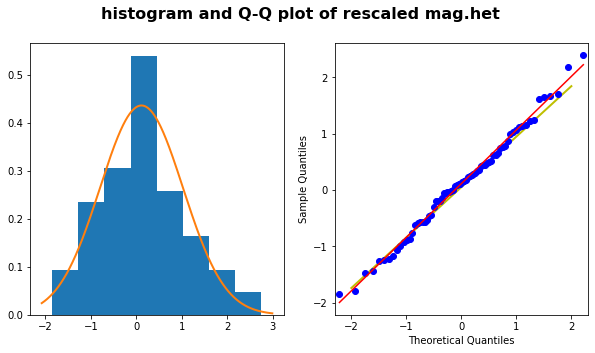

In [56]:
# method is from methods of moment in lecture example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('histogram and Q-Q plot of rescaled mag.het', size=16,fontweight="bold")
# let's histogram the sample we have 
ahist(df['new.mag.het'], bins='freedman', density=True, ax=ax1)
xmin, xmax = ax1.get_xlim()
xval = np.arange(xmin, xmax+0.01, 0.001)

# and overplot the PDF we estimate using the method of moments
estpdf  = st.norm.pdf(xval, loc=mean, scale=std)
ax1.plot(xval, estpdf, color='C1', lw=2)

ax2.plot(X, L, color='y', lw=2)

gofplots.qqplot(df['new.mag.het'], line='r', ax=ax2)
plt.show()

#### In mag.outlier histogram plot shows there are some outliers on the right and that is why we can see in qq plot that the samples on the very right (high quartile) have higher distance from the line. There is also an outlier on the left and that explains the distance from the line on the left (low quartile) of the distribution.
#### In mag.het qq plot, samples don't fall on line very well and the distance of the samples from the line is very random, the histogram of this data verifies this.
#### In the last part, we basically normalized the mag.het data by subtracting from mean and dividing by error data so it is not unexpected to fall on line better and shows a good normal distribution.

#### https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0

# Problem 3

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.

Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples (you can use `statsmodels` `astropy` `scipy` `numpy`....)
(Yes, we've not covered fitting straight lines. That's OK.)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). What do you see?

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.polynomial.polynomial import polyfit
%matplotlib inline

### Reading the file

In [58]:
path = "data/Cepheids.csv"
df = pd.read_csv(path)
df

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


### Split the data into LMC and SMC

In [59]:
LMC =  df[df['Cloud'] == 'LMC']
LMC

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
5632,OGLE-LMC-CEP-3368,5.266611,-69.513083,1,LMC,16.94960,-0.572217,0.548
5633,OGLE-LMC-CEP-3370,5.353917,-70.147611,1,LMC,16.79315,-0.569856,0.787
5634,OGLE-LMC-CEP-3371,5.526572,-70.094833,1,LMC,17.53350,-0.569003,0.570
5635,OGLE-LMC-CEP-3373,5.552631,-71.528361,1,LMC,17.51980,-0.558736,0.564


In [60]:
SMC =  df[df['Cloud'] == 'SMC']
SMC

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
1806,OGLE-SMC-CEP-0001,0.335519,-74.548530,F,SMC,16.45430,0.052410,0.554
1807,OGLE-SMC-CEP-0005,0.364969,-72.372970,F,SMC,16.29465,0.109718,0.557
1808,OGLE-SMC-CEP-0006,0.365656,-73.915530,F,SMC,16.06830,0.171660,0.674
1809,OGLE-SMC-CEP-0007,0.367853,-73.448670,F,SMC,16.13180,0.125224,0.644
1810,OGLE-SMC-CEP-0008,0.371878,-74.459390,F,SMC,16.80580,-0.028503,0.544
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


In [61]:
LMC_1 = LMC[LMC['Mode']=='1']
SMC_1 = SMC[SMC['Mode']=='1']
LMC_F = LMC[LMC['Mode']=='F']
SMC_F = SMC[SMC['Mode']=='F']

In [62]:
SMC_F.head()

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
1806,OGLE-SMC-CEP-0001,0.335519,-74.54853,F,SMC,16.45430,0.052410,0.554
1807,OGLE-SMC-CEP-0005,0.364969,-72.37297,F,SMC,16.29465,0.109718,0.557
1808,OGLE-SMC-CEP-0006,0.365656,-73.91553,F,SMC,16.06830,0.171660,0.674
1809,OGLE-SMC-CEP-0007,0.367853,-73.44867,F,SMC,16.13180,0.125224,0.644
1810,OGLE-SMC-CEP-0008,0.371878,-74.45939,F,SMC,16.80580,-0.028503,0.544


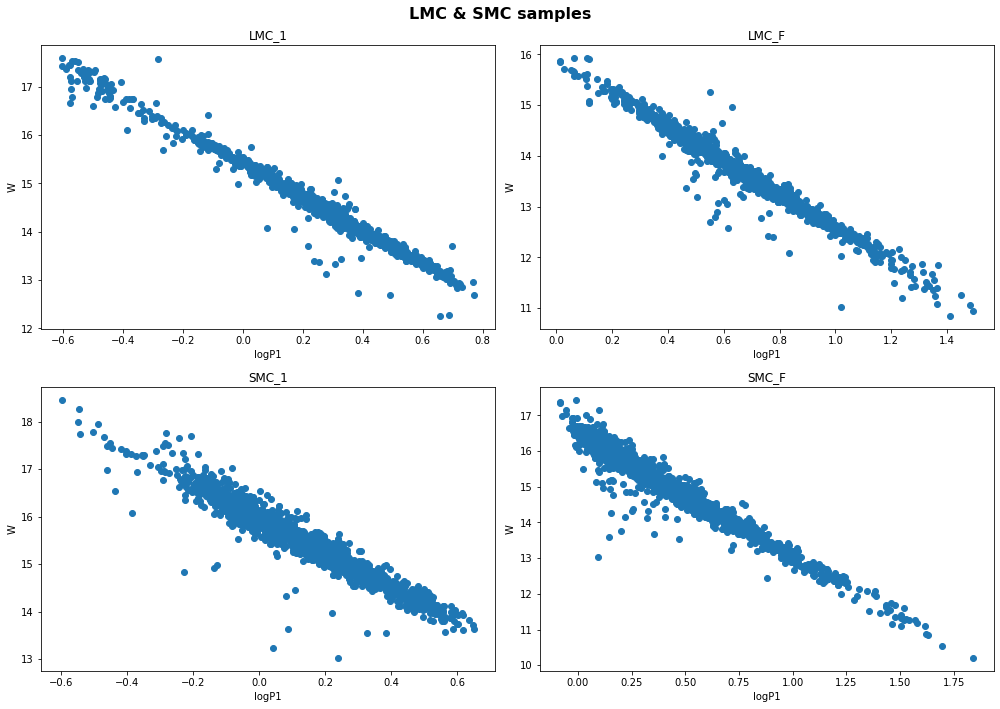

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('LMC & SMC samples', size=16,fontweight="bold")

# w on y-axis, log(p1) on x-axis
ax[0,0].scatter(x=LMC_1['logP1'], y=LMC_1['W'])
ax[0,0].set_ylabel('W')
ax[0,0].set_xlabel('logP1')
ax[0,0].title.set_text('LMC_1')

ax[0,1].scatter(x=LMC_F['logP1'], y=LMC_F['W'])
ax[0,1].set_ylabel('W')
ax[0,1].set_xlabel('logP1')
ax[0,1].title.set_text('LMC_F')

ax[1,0].scatter(x=SMC_1['logP1'], y=SMC_1['W'])
ax[1,0].set_ylabel('W')
ax[1,0].set_xlabel('logP1')
ax[1,0].title.set_text('SMC_1')

ax[1,1].scatter(x=SMC_F['logP1'], y=SMC_F['W'])
ax[1,1].set_ylabel('W')
ax[1,1].set_xlabel('logP1')
ax[1,1].title.set_text('SMC_F')

# set spacing
fig.tight_layout()
plt.show()

### Fit straight line for each sample

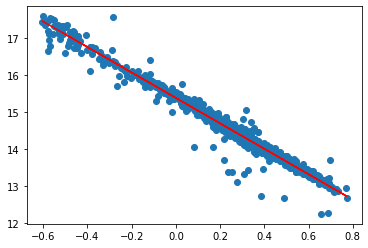

In [84]:
b, m = polyfit(LMC_1['logP1'], LMC_1['W'], 1) # b=offset, m=slope
y = LMC_1['W']
x= LMC_1['logP1']
plt.scatter(x, y)
plt.plot(x, b + m * x, '-', c='r')
plt.show()

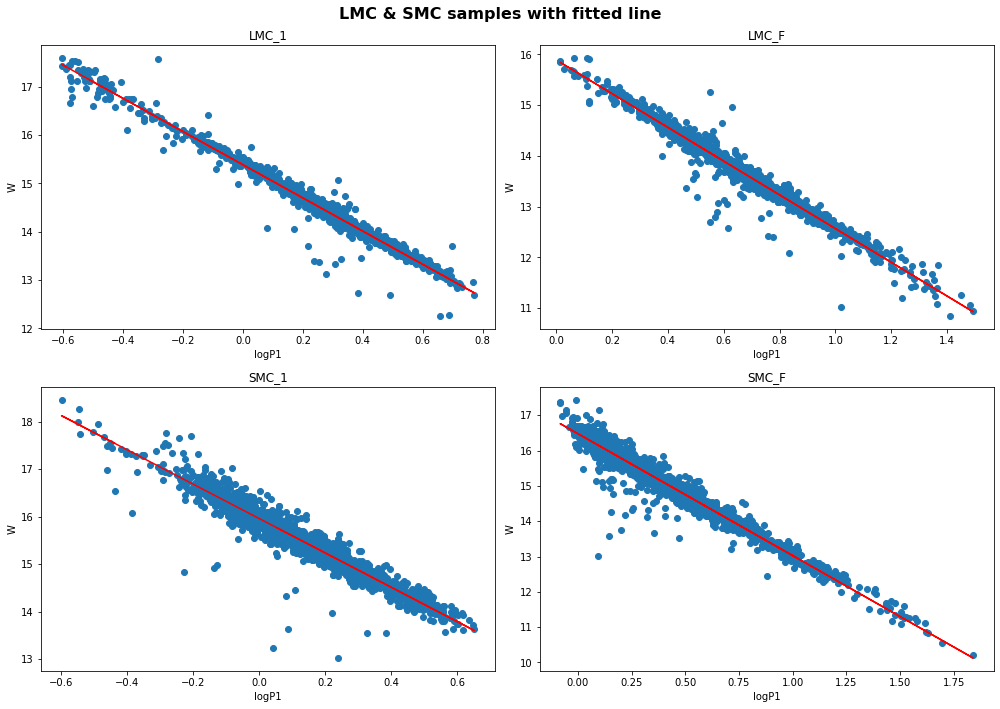

In [86]:
W, logP1 = 'W', 'logP1'
sets = [LMC_1, LMC_F, SMC_1, SMC_F]
b, m, y =[], [], []

fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('LMC & SMC samples with fitted line', size=16,fontweight="bold")

for s in sets:
    i, j = polyfit(s[logP1], s[W], 1)
    b.append(i)
    m.append(j)
    y.append(i+j*s[logP1])


ax[0,0].scatter(LMC_1['logP1'], LMC_1['W'])
ax[0,0].plot(LMC_1['logP1'], b[0] + m[0] * LMC_1['logP1'], '-', c='r')
ax[0,0].set_ylabel('W')
ax[0,0].set_xlabel('logP1')
ax[0,0].title.set_text('LMC_1')

ax[0,1].scatter(LMC_F['logP1'], LMC_F['W'])
ax[0,1].plot(LMC_F['logP1'], b[1] + m[1] * LMC_F['logP1'], '-', c='r')
ax[0,1].set_ylabel('W')
ax[0,1].set_xlabel('logP1')
ax[0,1].title.set_text('LMC_F')

ax[1,0].scatter(SMC_1['logP1'], SMC_1['W'])
ax[1,0].plot(SMC_1['logP1'], b[2] + m[2] * SMC_1['logP1'], '-', c='r')
ax[1,0].set_ylabel('W')
ax[1,0].set_xlabel('logP1')
ax[1,0].title.set_text('SMC_1')

ax[1,1].scatter(SMC_F['logP1'], SMC_F['W'])
ax[1,1].plot(SMC_F['logP1'], b[3] + m[3] * SMC_F['logP1'], '-', c='r')
ax[1,1].set_ylabel('W')
ax[1,1].set_xlabel('logP1')
ax[1,1].title.set_text('SMC_F')

# set spacing
fig.tight_layout()
plt.show()

### Computing residual of each sample from its line
### residual = actual y value - predicted y value

In [87]:
LMC_1['res'] = LMC_1[W] - (b[0] + m[0] * LMC_1[logP1])
LMC_F['res'] = LMC_F[W] - (b[1] + m[1] * LMC_F[logP1])
SMC_1['res'] = SMC_1[W] - (b[2] + m[2] * SMC_1[logP1])
SMC_F['res'] = SMC_F[W] - (b[3] + m[3] * SMC_F[logP1])

<ipython-input-87-53b41f30397a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMC_1['res'] = LMC_1[W] - (b[0] + m[0] * LMC_1[logP1])
<ipython-input-87-53b41f30397a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMC_F['res'] = LMC_F[W] - (b[1] + m[1] * LMC_F[logP1])
<ipython-input-87-53b41f30397a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [88]:
LMC_1

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI,res
4409,OGLE-LMC-CEP-0001,4.516036,-69.060389,1,LMC,17.16320,-0.513124,0.396,0.018075
4410,OGLE-LMC-CEP-0003,4.584919,-70.424139,1,LMC,17.05340,-0.455816,0.512,0.104969
4411,OGLE-LMC-CEP-0004,4.588931,-69.802139,1,LMC,14.26000,0.348228,0.560,0.071244
4412,OGLE-LMC-CEP-0006,4.595044,-69.724778,1,LMC,13.66160,0.517845,0.668,0.055012
4413,OGLE-LMC-CEP-0007,4.608347,-68.626583,1,LMC,15.95705,-0.149302,0.629,0.060651
...,...,...,...,...,...,...,...,...,...
5632,OGLE-LMC-CEP-3368,5.266611,-69.513083,1,LMC,16.94960,-0.572217,0.548,-0.398348
5633,OGLE-LMC-CEP-3370,5.353917,-70.147611,1,LMC,16.79315,-0.569856,0.787,-0.546695
5634,OGLE-LMC-CEP-3371,5.526572,-70.094833,1,LMC,17.53350,-0.569003,0.570,0.196583
5635,OGLE-LMC-CEP-3373,5.552631,-71.528361,1,LMC,17.51980,-0.558736,0.564,0.218122


In [89]:
LMC_1['res'] = np.where(LMC_1['res']>0,'orange','green')
LMC_1

<ipython-input-89-1948391ded79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMC_1['res'] = np.where(LMC_1['res']>0,'orange','green')


,name,RA0,Decl0,Mode,Cloud,W,logP1,VI,res
4409,OGLE-LMC-CEP-0001,4.516036,-69.060389,1,LMC,17.16320,-0.513124,0.396,orange
4410,OGLE-LMC-CEP-0003,4.584919,-70.424139,1,LMC,17.05340,-0.455816,0.512,orange
4411,OGLE-LMC-CEP-0004,4.588931,-69.802139,1,LMC,14.26000,0.348228,0.560,orange
4412,OGLE-LMC-CEP-0006,4.595044,-69.724778,1,LMC,13.66160,0.517845,0.668,orange
4413,OGLE-LMC-CEP-0007,4.608347,-68.626583,1,LMC,15.95705,-0.149302,0.629,orange
...,...,...,...,...,...,...,...,...,...
5632,OGLE-LMC-CEP-3368,5.266611,-69.513083,1,LMC,16.94960,-0.572217,0.548,green
5633,OGLE-LMC-CEP-3370,5.353917,-70.147611,1,LMC,16.79315,-0.569856,0.787,green
5634,OGLE-LMC-CEP-3371,5.526572,-70.094833,1,LMC,17.53350,-0.569003,0.570,orange
5635,OGLE-LMC-CEP-3373,5.552631,-71.528361,1,LMC,17.51980,-0.558736,0.564,orange


### Plot the residuals color coded by if they are positive or negative vs RA and Dec 

In [90]:
LMC_F['res'] = np.where(LMC_F['res']>0,'orange','green')
SMC_1['res'] = np.where(SMC_1['res']>0,'orange','green')
SMC_F['res'] = np.where(SMC_F['res']>0,'orange','green')

<ipython-input-90-8d8be5c2fddd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LMC_F['res'] = np.where(LMC_F['res']>0,'orange','green')
<ipython-input-90-8d8be5c2fddd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SMC_1['res'] = np.where(SMC_1['res']>0,'orange','green')
<ipython-input-90-8d8be5c2fddd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

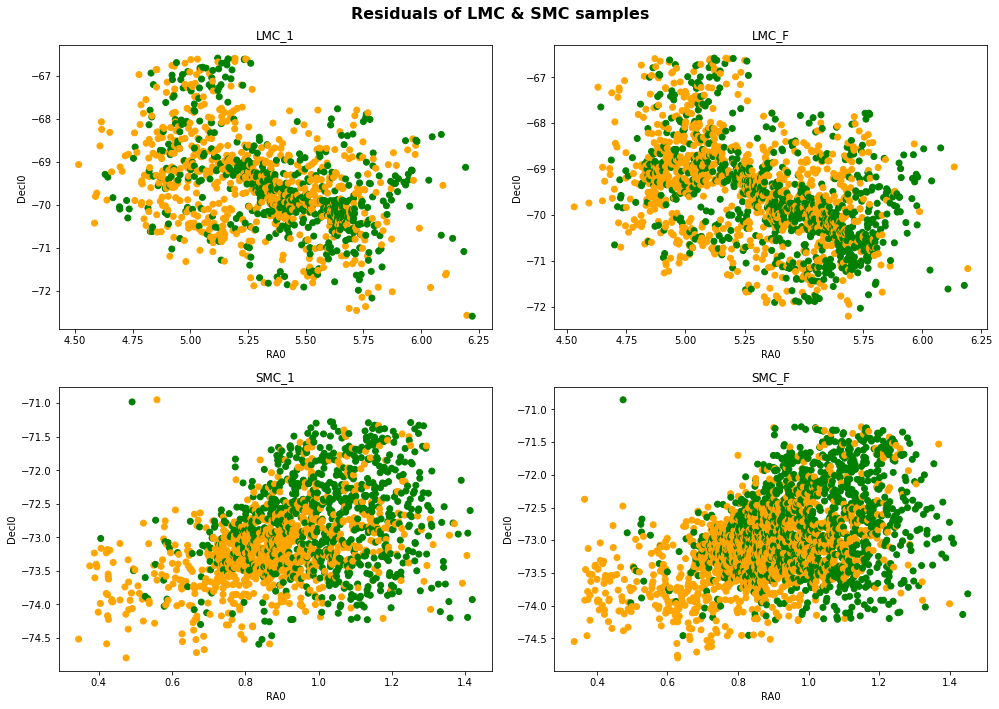

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Residuals of LMC & SMC samples', size=16,fontweight="bold")

ax[0,0].scatter(LMC_1['RA0'], LMC_1['Decl0'], color= LMC_1['res'])
ax[0,0].set_xlabel('RA0')
ax[0,0].set_ylabel('Decl0')
ax[0,0].title.set_text('LMC_1')

ax[0,1].scatter(LMC_F['RA0'], LMC_F['Decl0'], color= LMC_F['res'])
ax[0,1].set_xlabel('RA0')
ax[0,1].set_ylabel('Decl0')
ax[0,1].title.set_text('LMC_F')

ax[1,0].scatter(SMC_1['RA0'], SMC_1['Decl0'], color= SMC_1['res'])
ax[1,0].set_xlabel('RA0')
ax[1,0].set_ylabel('Decl0')
ax[1,0].title.set_text('SMC_1')

ax[1,1].scatter(SMC_F['RA0'], SMC_F['Decl0'], color= SMC_F['res'])
ax[1,1].set_xlabel('RA0')
ax[1,1].set_ylabel('Decl0')
ax[1,1].title.set_text('SMC_F')

# set spacing
fig.tight_layout()
plt.show()

#### we plot the luminosity vs log period of the samples and then we fit a line for each 4 dataframes. According to the Youtube video, there is a linear relationship between luminosity (in our dataset W column) and log periodand my plots can confirms this.
#### But I don't think residuals follow any linear line in ra vs dec plot! I think what we are trying to conclude here is that there is no correlation between residuals and coordinates of the cepheids stars

## Extra Credit: Homework Survey
https://forms.gle/YxoMdWDU5AhjzkDd8

In [103]:
# Did you fill it out? Yes, I did :)